# 무역 데이터 EDA (HS4 / item_id 단위 EDA 및 micro-level deep dive)

In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns

# 데이터 경로: 현재 노트북이 trade-comovement/analysis/에 있으므로 data/train.csv 사용
df_train = pd.read_csv('data/train.csv')
print(df_train.head(20))



     item_id  year  month  seq  type   hs4      weight  quantity       value
0   DEWLVASR  2022      1  1.0     1  3038     14858.0       0.0     32688.0
1   ELQGMQWE  2022      1  1.0     1  2002     62195.0       0.0    110617.0
2   AHMDUILJ  2022      1  1.0     1  2102     18426.0       0.0     72766.0
3   XIPPENFQ  2022      1  1.0     1  2501     20426.0       0.0     11172.0
4   FTSVTTSR  2022      1  1.0     1  2529    248000.0       0.0    143004.0
5   XMKRPGLB  2022      1  1.0     1  2529    558000.0       0.0    205676.0
6   RCBZUSIM  2022      1  1.0     1  2805         0.0       0.0       459.0
7   SUOYXCHP  2022      1  1.0     1  2805         0.0       0.0       482.0
8   ZKENOUDA  2022      1  1.0     1  2805         2.0       0.0      2783.0
9   WQMVCOEM  2022      1  1.0     1  2805       187.0       0.0    217777.0
10  BSRMSVTC  2022      1  1.0     1  2805       111.0       0.0     33952.0
11  DDEXPPXU  2022      1  1.0     1  2807       387.0       0.0     13158.0

## 1. 전처리

- zero / missing flag 생성:
  - value, weight, quantity의 0은 정상적일 수 있음 👉 제거 X
  - 대신 zero 패턴 자체를 feature로 인식하기 위해 flag 생성.

- 결측치 처리:
  - weight, quantity, value 결측은 보간하지 않음 (의미 있는 결측이기 때문)

- item_id / HS4 단위 monthly pivot 생성
  - → Comovement 분석의 기본 단위로 사용될 시계열 구조 확보.

In [2]:
# Zero flag 생성
df_train['value_zero'] = (df_train['value'] == 0).astype(int)
df_train['weight_zero'] = (df_train['weight'] == 0).astype(int)
df_train['quantity_zero'] = (df_train['quantity'] == 0).astype(int)

# Missing flag 생성
df_train['value_missing'] = df_train['value'].isna().astype(int)
df_train['weight_missing'] = df_train['weight'].isna().astype(int)
df_train['quantity_missing'] = df_train['quantity'].isna().astype(int)

In [3]:
hs2_map = {
    "01": "산동물",
    "02": "육과 식용설육",
    "03": "어패류",
    "04": "낙농품·조란·천연동물성 식품",
    "05": "기타 동물성 생산품",
    "06": "산수목·꽃",
    "07": "채소",
    "08": "과실·견과류",
    "09": "커피·향신료",

    "10": "곡물",
    "11": "밀가루·전분",
    "12": "채유용 종자·인삼",
    "13": "식물성 엑스",
    "14": "기타 식물성 생산품",
    "15": "동식물성 유지",
    "16": "육·어류 조제품",
    "17": "당류·설탕과자",
    "18": "코코아·초콜릿",
    "19": "곡물·곡분 주제품·빵류",

    "20": "채소·과실의 조제품",
    "21": "기타 조제식료품",
    "22": "음료·주류·식초",
    "23": "조제사료",
    "24": "담배",
    "25": "토석류·소금",
    "26": "광·슬랙·회",
    "27": "광물성 연료·에너지",
    "28": "무기화합물",
    "29": "유기화합물",

    "30": "의료용품",
    "31": "비료",
    "32": "염료·안료·페인트·잉크",
    "33": "향료·화장품",
    "34": "비누·계면활성제·왁스",
    "35": "카세인·알부민·변성전분·효소",
    "36": "화약류·성냥",
    "37": "필름·인화지·사진용 재료",
    "38": "기타 화학공업 품목",
    "39": "플라스틱과 그 제품",

    "40": "고무와 그 제품",
    "41": "원피·가죽",
    "42": "가죽제품",
    "43": "모피·모피제품",
    "44": "목재·목탄",
    "45": "코르크·코르크 제품",
    "46": "조물재료 제품",
    "47": "펄프",
    "48": "지·판지",
    "49": "서적·신문·인쇄물",

    "50": "견·견사·견직물",
    "51": "양모·수모",
    "52": "면·면사·면직물",
    "53": "마류사·직물",
    "54": "인조 필라멘트 섬유",
    "55": "인조 스테이플 섬유",
    "56": "워딩·부직포",
    "57": "양탄자",
    "58": "특수 직물",
    "59": "침투·도포 직물",

    "60": "편물",
    "61": "의류(편물제)",
    "62": "의류(편물제 외)",
    "63": "기타 섬유제품·넝마",
    "64": "신발류",
    "65": "모자류",
    "66": "우산·지팡이",
    "67": "조제 우모·인조제품",
    "68": "석·시멘트·석면 제품",
    "69": "도자 제품",

    "70": "유리",
    "71": "귀석·반귀석·귀금속",
    "72": "철강",
    "73": "철강제품",
    "74": "동과 그 제품",
    "75": "니켈과 그 제품",
    "76": "알루미늄과 그 제품",
    "78": "연과 그 제품",
    "79": "아연과 그 제품",

    "80": "주석과 그 제품",
    "81": "기타 비금속",
    "82": "비금속 공구·스푼·포크",
    "83": "각종 비금속 제품",
    "84": "보일러·기계류",
    "85": "전기기기·TV·VTR",
    "86": "철도차량",
    "87": "일반차량",
    "88": "항공기",
    "89": "선박",

    "90": "광학·의료·측정·정밀기기",
    "91": "시계",
    "92": "악기",
    "93": "무기",
    "94": "가구·조명기구",
    "95": "완구·운동용품",
    "96": "잡품",
    "97": "예술품·골동품"
}


### 모든 item_id × 모든 month 패널 완성(Panel Completion)

현재 데이터는 모든 item_id가 모든 월에 등장하지 않음 → 공행성 분석에서 큰 문제됨.
동시에 존재하는 시계열끼리 비교해야 함

예:
- A item은 2022~2025 전 기간 존재
- B item은 특정 계절만 존재
- C item은 중간에 구멍 있음

이런 상태에서 comovement correlation 계산하면 시계열 길이가 불일치 → 오류 / 왜곡 발생, 상관계수 계산 불가<br>
- A : 2022.01 ~ 2025.07 모든 달에 존재 = 42개월
- C : 2022.03 ~ 2023.05 일부 달에 존재 = 15개월
→ 반드시 해야 하는 전처리:<br>
모든 item_id × 모든 month 조합을 만들고 없는 row는 0 또는 NaN으로 채우기

✅ 1단계: df_train에 date 컬럼 붙이기

아래 셀을 통째로 새로 실행해 줘:

✅ 2단계: panel(모든 item_id × 모든 month) 만들기

이제 date가 생겼다고 가정하고, 아래 셀 실행 👇

In [4]:
import pandas as pd

# ------------------------------------
# 0) date 컬럼 만들기 (year, month 기준)
# ------------------------------------
# year, month가 있고 date가 아직 없을 때만 생성
if "date" not in df_train.columns:
    df_train["date"] = pd.to_datetime(
        df_train["year"].astype(int).astype(str) + "-" +
        df_train["month"].astype(int).astype(str) + "-01"
    )

# 혹시 date가 object/string인 경우 datetime으로 변환
df_train["date"] = pd.to_datetime(df_train["date"])

# ------------------------------------
# 1) 월별 집계 (중복거래 제거 핵심)
#    item_id + hs4 + date 기준으로 value/weight/quantity 합산
# ------------------------------------
agg_cols = ["value", "weight", "quantity"]

df_train_monthly = (
    df_train
    .groupby(["item_id", "hs4", "date"], as_index=False)[agg_cols]
    .sum()
)

print("월별 집계 결과 예시:")
print(df_train_monthly.head())

# ------------------------------------
# 2) 전체 month 범위 & item_id 목록 만들기
# ------------------------------------
min_month = df_train_monthly["date"].min()
max_month = df_train_monthly["date"].max()

full_months = pd.date_range(min_month, max_month, freq="MS")
all_items = df_train_monthly["item_id"].unique()

# ------------------------------------
# 3) item_id × date 전체 조합 (풀 패널 인덱스)
# ------------------------------------
panel = pd.MultiIndex.from_product(
    [all_items, full_months],
    names=["item_id", "date"]
).to_frame(index=False)

# ------------------------------------
# 4) 집계된 df_train_monthly와 merge해서 패널 완성
# ------------------------------------
df_panel = (
    panel.merge(df_train_monthly, on=["item_id", "date"], how="left")
         .sort_values(["item_id", "date"])
         .reset_index(drop=True)
)

# 거래 없던 month → NaN을 0으로 채우기 (원하면)
for c in agg_cols:
    df_panel[c] = df_panel[c].fillna(0)

# 연/월 컬럼 다시 생성
df_panel["year"] = df_panel["date"].dt.year
df_panel["month"] = df_panel["date"].dt.month

print("최종 패널 예시:")
print(df_panel.head())

# 중복 체크 (item_id, date 조합이 유일한지)
print("중복 row 개수:", df_panel.duplicated(["item_id", "date"]).sum())


월별 집계 결과 예시:
    item_id   hs4       date    value    weight  quantity
0  AANGBULD  4810 2022-01-01  14276.0   17625.0       0.0
1  AANGBULD  4810 2022-02-01  52347.0   67983.0       0.0
2  AANGBULD  4810 2022-03-01  53549.0   69544.0       0.0
3  AANGBULD  4810 2022-05-01  26997.0   34173.0       0.0
4  AANGBULD  4810 2022-06-01  84489.0  103666.0       0.0
최종 패널 예시:
    item_id       date     hs4    value   weight  quantity  year  month
0  AANGBULD 2022-01-01  4810.0  14276.0  17625.0       0.0  2022      1
1  AANGBULD 2022-02-01  4810.0  52347.0  67983.0       0.0  2022      2
2  AANGBULD 2022-03-01  4810.0  53549.0  69544.0       0.0  2022      3
3  AANGBULD 2022-04-01     NaN      0.0      0.0       0.0  2022      4
4  AANGBULD 2022-05-01  4810.0  26997.0  34173.0       0.0  2022      5
중복 row 개수: 0


In [5]:
df_panel.duplicated(["item_id", "date"]).sum()

np.int64(0)

In [6]:
df_panel["hs2"] = df_panel["hs4"].astype(str).str[:2]
df_panel["hs2_name_kr"] = df_panel["hs2"].map(hs2_map)

In [7]:
#df_panel.isnull().sum()
#df_panel[df_panel['seq'].isnull()]

#df_panel.duplicated().sum()
df_panel.head()


,item_id,date,hs4,value,weight,quantity,year,month,hs2,hs2_name_kr
0,AANGBULD,2022-01-01,4810.0,14276.0,17625.0,0.0,2022,1,48,지·판지
1,AANGBULD,2022-02-01,4810.0,52347.0,67983.0,0.0,2022,2,48,지·판지
2,AANGBULD,2022-03-01,4810.0,53549.0,69544.0,0.0,2022,3,48,지·판지
3,AANGBULD,2022-04-01,NaN,0.0,0.0,0.0,2022,4,na,NaN
4,AANGBULD,2022-05-01,4810.0,26997.0,34173.0,0.0,2022,5,48,지·판지


In [8]:
# 거래량 관련 수치 컬럼
value_cols = ['value', 'weight', 'quantity']

# 없는 월은 거래 0으로 (너 프로젝트 설정에 따라 조정 가능)
df_panel[value_cols] = df_panel[value_cols].fillna(0)

# ===== 개선 1: HS4 매핑 보완 =====
# item_id는 항상 같은 HS4를 가지므로 (1:1 관계), Panel에서 NaN인 HS4를 채움
print("HS4 매핑 보완 중...")
item_hs4_mapping = (
    df_panel[df_panel['hs4'].notna()]
    .groupby('item_id')['hs4']
    .first()  # 모든 값이 같으므로 first() 사용
    .to_dict()
)

# Panel의 NaN 채우기
hs4_before = df_panel['hs4'].isna().sum()
df_panel['hs4'] = df_panel['item_id'].map(item_hs4_mapping).fillna(df_panel['hs4'])
hs4_after = df_panel['hs4'].isna().sum()
print(f"  - HS4 NaN 개수: {hs4_before} → {hs4_after}")

# HS4별 item_id 수 통계 확인 (1:N 관계)
hs4_item_count = df_panel.groupby('hs4')['item_id'].nunique()
print(f"  - HS4별 평균 item_id 수: {hs4_item_count.mean():.2f}개")
print(f"  - 최대 item_id 수를 가진 HS4: {int(hs4_item_count.idxmax())} ({hs4_item_count.max()}개)")

# ===== Zero/Missing Flag 생성 =====
# df_panel에는 flag가 없으므로 직접 생성
print("Zero/Missing Flag 생성 중...")
df_panel['value_zero'] = (df_panel['value'] == 0).astype(int)
df_panel['weight_zero'] = (df_panel['weight'] == 0).astype(int)
df_panel['quantity_zero'] = (df_panel['quantity'] == 0).astype(int)

df_panel['value_missing'] = df_panel['value'].isna().astype(int)
df_panel['weight_missing'] = df_panel['weight'].isna().astype(int)
df_panel['quantity_missing'] = df_panel['quantity'].isna().astype(int)

print("  - Zero/Missing Flag 생성 완료")

df_panel.head()
df_panel[df_panel['item_id'] == 'GKQIJYDH']

HS4 매핑 보완 중...
  - HS4 NaN 개수: 524 → 0
  - HS4별 평균 item_id 수: 1.41개
  - 최대 item_id 수를 가진 HS4: 2805 (6개)
Zero/Missing Flag 생성 중...
  - Zero/Missing Flag 생성 완료


,item_id,date,hs4,value,weight,quantity,year,month,hs2,hs2_name_kr,value_zero,weight_zero,quantity_zero,value_missing,weight_missing,quantity_missing
1247,GKQIJYDH,2022-01-01,8501.0,9782469.0,579404.0,68.0,2022,1,85,전기기기·TV·VTR,0,0,0,0,0,0
1248,GKQIJYDH,2022-02-01,8501.0,321176.0,50685.0,31.0,2022,2,85,전기기기·TV·VTR,0,0,0,0,0,0
1249,GKQIJYDH,2022-03-01,8501.0,7106218.0,416214.0,68.0,2022,3,85,전기기기·TV·VTR,0,0,0,0,0,0
1250,GKQIJYDH,2022-04-01,8501.0,17850488.0,854306.0,550.0,2022,4,85,전기기기·TV·VTR,0,0,0,0,0,0
1251,GKQIJYDH,2022-05-01,8501.0,41768869.0,3025992.0,181.0,2022,5,85,전기기기·TV·VTR,0,0,0,0,0,0
1252,GKQIJYDH,2022-06-01,8501.0,11677001.0,698063.0,125.0,2022,6,85,전기기기·TV·VTR,0,0,0,0,0,0
1253,GKQIJYDH,2022-07-01,8501.0,8420099.0,630011.0,88.0,2022,7,85,전기기기·TV·VTR,0,0,0,0,0,0
1254,GKQIJYDH,2022-08-01,8501.0,14228993.0,794488.0,108.0,2022,8,85,전기기기·TV·VTR,0,0,0,0,0,0
1255,GKQIJYDH,2022-09-01,8501.0,19845420.0,741487.0,110.0,2022,9,85,전기기기·TV·VTR,0,0,0,0,0,0
1256,GKQIJYDH,2022-10-01,8501.0,9518385.0,378466.0,123.0,2022,10,85,전기기기·TV·VTR,0,0,0,0,0,0


## 1-1. 전처리 개선: 공급망 정보 추가


In [9]:
# ===== 개선 2: 공급망 정보 추가 =====
def get_supply_chain_tier(hs4):
    """HS4 코드를 기반으로 공급망 계층 반환"""
    if pd.isna(hs4):
        return 0
    hs4_int = int(hs4)
    if 2800 <= hs4_int <= 3899:  # 화학제품
        return 1  # Tier 1 (원자재)
    elif 7200 <= hs4_int <= 8399:  # 금속제품
        return 2  # Tier 2 (중간재)
    elif 8400 <= hs4_int <= 8599:  # 기계류
        return 3  # Tier 3 (최종제품)
    else:
        return 0  # 기타

# 공급망 계층 추가
df_panel['supply_chain_tier'] = df_panel['hs4'].apply(get_supply_chain_tier)

# Tier별 분포 확인
print("공급망 계층 분포:")
print(df_panel['supply_chain_tier'].value_counts().sort_index())
print(f"\nTier별 item_id 수:")
for tier in [0, 1, 2, 3]:
    tier_items = df_panel[df_panel['supply_chain_tier'] == tier]['item_id'].nunique()
    tier_names = {0: '기타', 1: 'Tier 1 (원자재)', 2: 'Tier 2 (중간재)', 3: 'Tier 3 (최종제품)'}
    print(f"  {tier_names[tier]}: {tier_items}개")

# HS4별 item_id 수 (같은 HS4를 가진 item_id가 몇 개인지)
# → 공급망에서 해당 HS4의 중요도/다양성 지표로 활용 가능
hs4_item_count = df_panel.groupby('hs4')['item_id'].nunique().to_dict()
df_panel['hs4_item_count'] = df_panel['hs4'].map(hs4_item_count).fillna(0)

# HS4별 평균 거래량 (같은 HS4 그룹의 평균과 비교)
hs4_avg_value = df_panel.groupby('hs4')['value'].mean().to_dict()
df_panel['hs4_avg_value'] = df_panel['hs4'].map(hs4_avg_value).fillna(0)
df_panel['value_vs_hs4_avg'] = df_panel['value'] / (df_panel['hs4_avg_value'] + 1e-8)

print(f"\n공급망 정보 추가 완료!")
print(f"  - 추가된 컬럼: supply_chain_tier, hs4_item_count, hs4_avg_value, value_vs_hs4_avg")
df_panel[['item_id', 'hs4', 'supply_chain_tier', 'hs4_item_count', 'value_vs_hs4_avg']].head(10)


공급망 계층 분포:
supply_chain_tier
0    1591
1    1849
2     344
3     516
Name: count, dtype: int64

Tier별 item_id 수:
  기타: 37개
  Tier 1 (원자재): 43개
  Tier 2 (중간재): 8개
  Tier 3 (최종제품): 12개

공급망 정보 추가 완료!
  - 추가된 컬럼: supply_chain_tier, hs4_item_count, hs4_avg_value, value_vs_hs4_avg


,item_id,hs4,supply_chain_tier,hs4_item_count,value_vs_hs4_avg
0,AANGBULD,4810.0,0,1,0.169917
1,AANGBULD,4810.0,0,1,0.623047
2,AANGBULD,4810.0,0,1,0.637354
3,AANGBULD,4810.0,0,1,0.000000
4,AANGBULD,4810.0,0,1,0.321325
5,AANGBULD,4810.0,0,1,1.005610
6,AANGBULD,4810.0,0,1,0.000000
7,AANGBULD,4810.0,0,1,0.000000
8,AANGBULD,4810.0,0,1,0.000000
9,AANGBULD,4810.0,0,1,0.000000


## 1-2. 전처리 개선: 시계열 특성 추출


In [10]:
# ===== 개선 3: 시계열 특성 추출 =====
df_panel = df_panel.sort_values(['item_id', 'date']).reset_index(drop=True)

# 1. 이동평균 (Moving Average)
print("시계열 특성 추출 중...")
for window in [3, 6, 12]:  # 3개월, 6개월, 12개월 이동평균
    df_panel[f'value_ma{window}'] = (
        df_panel.groupby('item_id')['value']
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )
    print(f"  - {window}개월 이동평균 추가 완료")

# 2. 변화율 (Percentage Change)
df_panel['value_pct_change'] = (
    df_panel.groupby('item_id')['value'].pct_change()
)
df_panel['value_pct_change'] = df_panel['value_pct_change'].fillna(0)
print("  - 변화율 추가 완료")

# 3. 계절성 (Seasonality)
df_panel['month_sin'] = np.sin(2 * np.pi * df_panel['month'] / 12)
df_panel['month_cos'] = np.cos(2 * np.pi * df_panel['month'] / 12)
df_panel['quarter'] = df_panel['month'].apply(lambda x: (x-1)//3 + 1)
print("  - 계절성 특성 추가 완료 (month_sin, month_cos, quarter)")

# 4. 추세 (Trend) - 선형 추세 점수
def calculate_trend(series):
    """시계열의 선형 추세 기울기 계산"""
    if len(series) < 2:
        return 0
    x = np.arange(len(series))
    try:
        coeffs = np.polyfit(x, series, 1)
        return coeffs[0]  # 기울기
    except:
        return 0

df_panel['value_trend'] = (
    df_panel.groupby('item_id')['value']
    .transform(lambda x: calculate_trend(x.values))
)
print("  - 추세 특성 추가 완료")

# 5. 로그 변환 (스케일 조정)
df_panel['value_log'] = np.log1p(df_panel['value'])  # log1p: 0 값 처리
df_panel['weight_log'] = np.log1p(df_panel['weight'])
print("  - 로그 변환 추가 완료")

print(f"\n시계열 특성 추출 완료!")
print(f"  - 총 추가된 컬럼: value_ma3, value_ma6, value_ma12, value_pct_change, ")
print(f"    month_sin, month_cos, quarter, value_trend, value_log, weight_log")

# 결과 확인
df_panel[['item_id', 'date', 'value', 'value_ma6', 'value_pct_change', 
          'value_trend', 'value_log']].head(15)


시계열 특성 추출 중...
  - 3개월 이동평균 추가 완료
  - 6개월 이동평균 추가 완료
  - 12개월 이동평균 추가 완료
  - 변화율 추가 완료
  - 계절성 특성 추가 완료 (month_sin, month_cos, quarter)
  - 추세 특성 추가 완료
  - 로그 변환 추가 완료

시계열 특성 추출 완료!
  - 총 추가된 컬럼: value_ma3, value_ma6, value_ma12, value_pct_change, 
    month_sin, month_cos, quarter, value_trend, value_log, weight_log


,item_id,date,value,value_ma6,value_pct_change,value_trend,value_log
0,AANGBULD,2022-01-01,14276.0,14276.000000,0.000000,5674.875566,9.566405
1,AANGBULD,2022-02-01,52347.0,33311.500000,2.666783,5674.875566,10.865669
2,AANGBULD,2022-03-01,53549.0,40057.333333,0.022962,5674.875566,10.888371
3,AANGBULD,2022-04-01,0.0,30043.000000,-1.000000,5674.875566,0.000000
4,AANGBULD,2022-05-01,26997.0,29433.800000,inf,5674.875566,10.203518
5,AANGBULD,2022-06-01,84489.0,38609.666667,2.129570,5674.875566,11.344388
6,AANGBULD,2022-07-01,0.0,36230.333333,-1.000000,5674.875566,0.000000
7,AANGBULD,2022-08-01,0.0,27505.833333,0.000000,5674.875566,0.000000
8,AANGBULD,2022-09-01,0.0,18581.000000,0.000000,5674.875566,0.000000
9,AANGBULD,2022-10-01,0.0,18581.000000,0.000000,5674.875566,0.000000


## 2. HS4 / item_id 군집성 분석

In [11]:
df = df_panel.copy() 

hs4_summary = (
    df.groupby("hs4")[["value", "weight"]]
      .mean()
      .reset_index()
      .sort_values("value", ascending=False)
)

hs4_summary.head(10)
# 어떤 HS4 품목군의 평균 거래금액과 평균 중량이 높은지 파악
# 품목군의 경제적 규모 이해

,hs4,value,weight
11,2814.0,5.999737e+07,1.022512e+08
54,6211.0,2.516274e+07,8.551477e+05
32,3824.0,2.207718e+07,7.306599e+06
23,3102.0,1.754666e+07,3.233097e+07
70,9403.0,1.721897e+07,6.029486e+06
65,8505.0,1.216691e+07,3.952844e+05
31,3815.0,9.287355e+06,8.294349e+05
63,8479.0,6.980014e+06,3.525974e+05
14,2836.0,6.607692e+06,2.160214e+07
13,2833.0,6.410191e+06,1.476980e+06


In [12]:

hs4_qty_rate = (
    df.assign(qty_valid=(df["quantity"] > 0))
      .groupby("hs4")["qty_valid"]
      .mean()
      .reset_index(name="quantity_usage_rate")
      .sort_values("quantity_usage_rate", ascending=False)
)

hs4_qty_rate.head(10)
# 어떤 HS4는 quantity가 자주 기록되지만
# 어떤 HS4는 quantity가 거의 0 또는 누락
# 품목군 특성 파악, 모델링 시 quantity를 feature로 사용할지 판단

,hs4,quantity_usage_rate
35,4202.0,1.000000
53,6101.0,1.000000
42,5111.0,1.000000
45,5309.0,1.000000
48,5515.0,1.000000
51,5705.0,1.000000
54,6211.0,1.000000
66,8527.0,1.000000
47,5512.0,0.976744
61,8461.0,0.930233


In [13]:
item_volume = (
    df.groupby("item_id")["value"]
      .sum()
      .reset_index()
      .sort_values("value", ascending=False)
)

top_items = item_volume.head(20)
bottom_items = item_volume.tail(20)

top_items, bottom_items

# 가장 거래규모가 큰 품목과 작은 품목
# 예측 우선순위 선정, 군집분석 시 중요


(     item_id         value
 21  FCYBOAXC  4.671997e+09
 4   ATLDMDBO  2.579887e+09
 31  GYHKIVQT  1.456760e+09
 12  CCLHWFWF  1.081998e+09
 74  STZDBITS  1.057606e+09
 45  LRVGFDFM  8.040184e+08
 11  BUZIIBYG  7.404158e+08
 10  BTMOEMEP  7.049946e+08
 29  GKQIJYDH  6.070892e+08
 72  SDWAYPIK  4.381489e+08
 88  WPQXWHYO  4.093971e+08
 42  KJNSOAHR  3.001406e+08
 17  DNMPSKTB  2.888946e+08
 33  HXYSSRXE  2.841308e+08
 48  LUENUFGA  2.756382e+08
 37  JPBRUTWP  2.664403e+08
 61  QRKRBYJL  2.214571e+08
 6   BEZYMBBT  2.123930e+08
 20  EVBVXETX  1.975996e+08
 94  XUOIQPFL  1.960189e+08,
      item_id     value
 14  DDEXPPXU  820507.0
 38  JSLXRQOK  651539.0
 34  IGDVVKUD  606705.0
 8   BLANHGYY  541289.0
 65  RCBZUSIM  540481.0
 58  PYZMVUWD  530103.0
 99  ZXERAXWP  485789.0
 2   ANWUJOKX  350309.0
 36  JERHKLYW  334445.0
 22  FDXPMYGF  219744.0
 51  NAQIHUKZ  202508.0
 27  FWUCPMMW   97723.0
 95  YSYHGLQK   95838.0
 28  GIKPEWTY   94461.0
 16  DJBLNPNC   85293.0
 57  PLMZALFA    5385.0
 76

In [14]:
item_month_coverage = (
    df.groupby("item_id")["date"]
      .nunique()
      .reset_index(name="month_covered")
      .sort_values("month_covered", ascending=False)
)

item_month_coverage.head()
# 모든 item_id가 모든 월에 등장하는지 확인
# 모든 월에 등장하는 item_id만 모델링에 활용

#item_month_coverage.tail()
# 모든 월에 등장하지 않는 item_id는 모델링에서 제외


,item_id,month_covered
0,AANGBULD,43
63,QVLMOEYE,43
73,SNHYOVBM,43
72,SDWAYPIK,43
71,SAHWCZNH,43


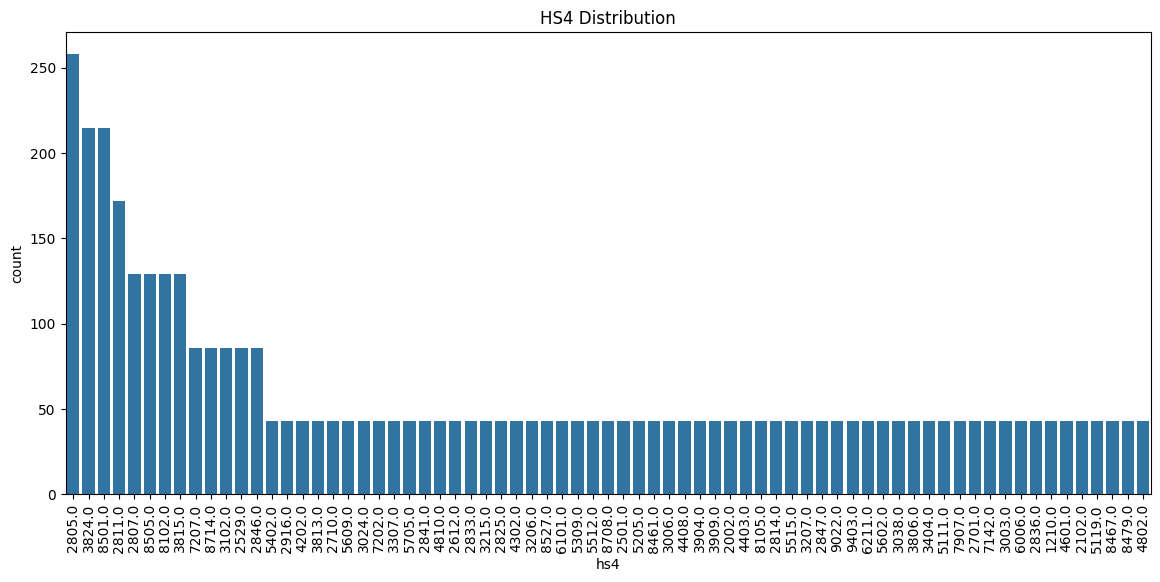

In [15]:
# HS4 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.countplot(data=df, x="hs4", order=df["hs4"].value_counts().index)
plt.xticks(rotation=90)
plt.title("HS4 Distribution")
plt.show()

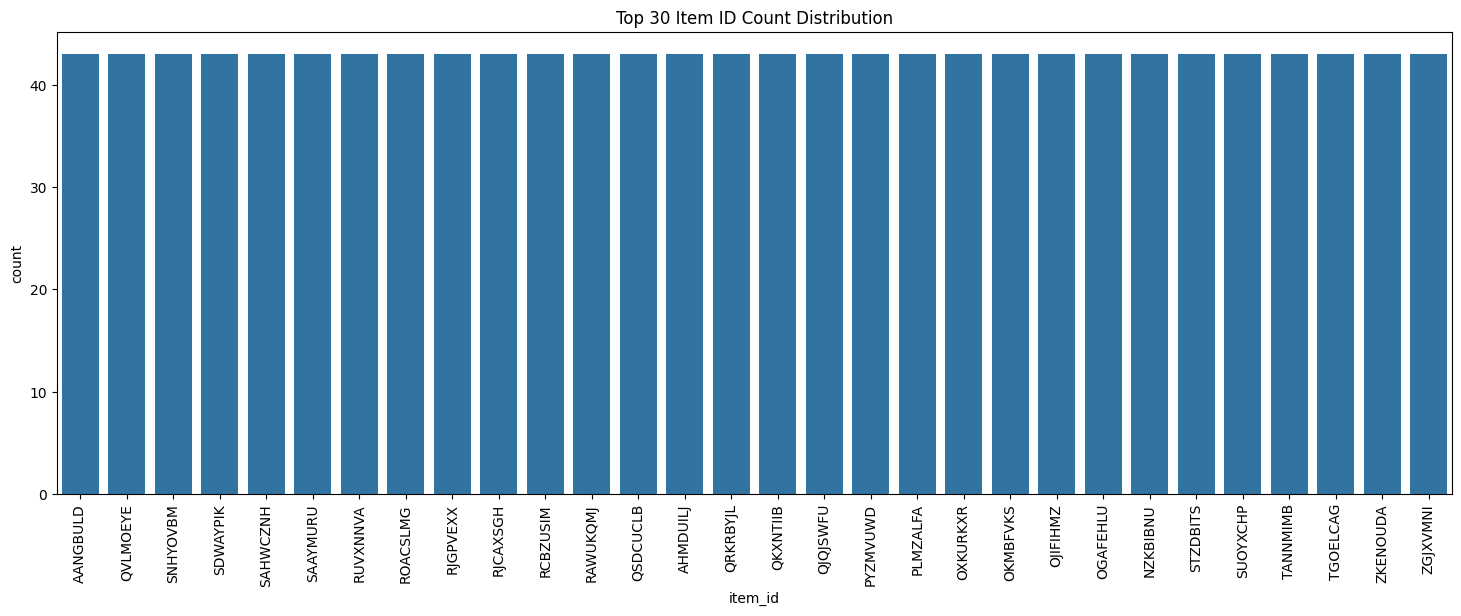

In [16]:
# item_id 분포 시각화

plt.figure(figsize=(18,6))
sns.countplot(data=df, x="item_id", order=df["item_id"].value_counts().index[:30])
plt.xticks(rotation=90)
plt.title("Top 30 Item ID Count Distribution")
plt.show()

## 3. item_id Micro-level Deep Dive

- item_id 5~10개 랜덤 추출
- 월별 value / weight / quantity 시계열 패턴 분석
- zero 패턴(0 비율) 분석
- 결측 패턴(NaN 비율) 분석
- 급증/급감(anomaly) 탐지
- HS 코드 cross-check (item_id에 여러 HS4가 존재하는지)
- 각 item_id별 상세 그래프 자동 생성(멀티 플롯)

In [17]:
import numpy as np

# df_panel 기준 사용
df = df_panel.copy()

# 8개 랜덤 sample
sample_items = np.random.choice(df['item_id'].unique(), size=8, replace=False)
sample_df = df[df['item_id'].isin(sample_items)]

monthly_trend = (
    sample_df.groupby(['item_id', 'date'])
             [['value', 'weight', 'quantity']]
             .sum()
             .reset_index()
)

monthly_trend.head()

,item_id,date,value,weight,quantity
0,CCLHWFWF,2022-01-01,40245617.0,1063806.0,3093546.0
1,CCLHWFWF,2022-02-01,42903738.0,1179288.0,3640542.0
2,CCLHWFWF,2022-03-01,39838394.0,1187807.0,3552203.0
3,CCLHWFWF,2022-04-01,26625256.0,917760.0,3024792.0
4,CCLHWFWF,2022-05-01,16264199.0,676426.0,2269412.0


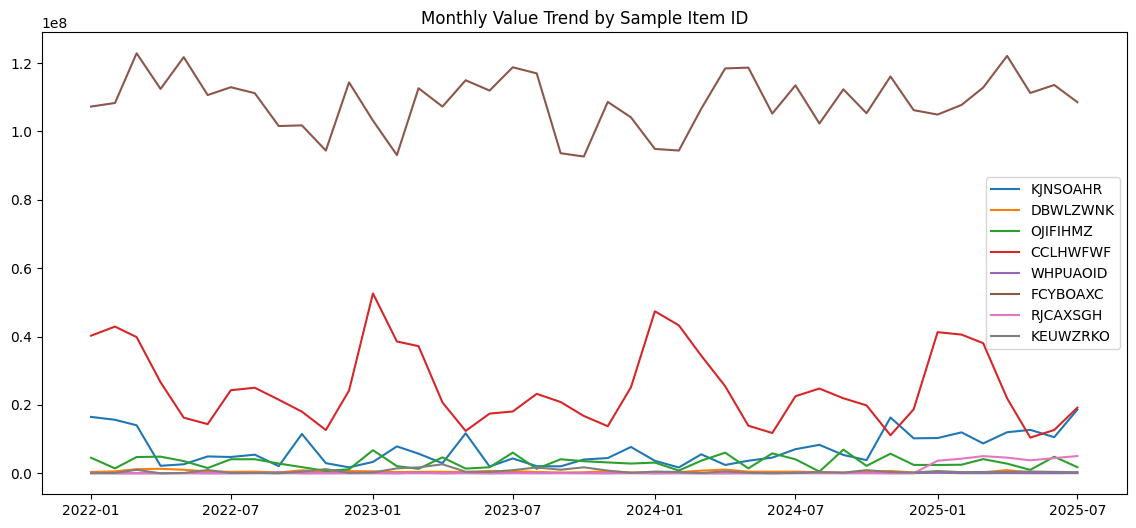

,item_id,date,value,weight,quantity


In [18]:
# 8개 item value 변화 시계열 그래프
plt.figure(figsize=(14,6))
for item in sample_items:
    tmp = monthly_trend[monthly_trend['item_id'] == item]
    plt.plot(tmp['date'], tmp['value'], label=item)

plt.title("Monthly Value Trend by Sample Item ID")
plt.legend()
plt.show()

monthly_trend[monthly_trend['item_id'] == 'GKQIJYDH']

In [19]:
df.head()
df.duplicated().sum()

np.int64(0)

In [20]:
# Zero / Missing 패턴 분석
zero_missing_stats = (
    df[df['item_id'].isin(sample_items)]
    .groupby('item_id')[['value_zero', 'weight_zero', 'quantity_zero',
                         'value_missing', 'weight_missing', 'quantity_missing']]
    .mean()
    .reset_index()
)

zero_missing_stats

,item_id,value_zero,weight_zero,quantity_zero,value_missing,weight_missing,quantity_missing
0,CCLHWFWF,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,DBWLZWNK,0.000000,0.000000,1.000000,0.0,0.0,0.0
2,FCYBOAXC,0.000000,0.000000,1.000000,0.0,0.0,0.0
3,KEUWZRKO,0.000000,0.000000,1.000000,0.0,0.0,0.0
4,KJNSOAHR,0.000000,0.000000,1.000000,0.0,0.0,0.0
5,OJIFIHMZ,0.000000,0.000000,1.000000,0.0,0.0,0.0
6,RJCAXSGH,0.837209,0.837209,0.837209,0.0,0.0,0.0
7,WHPUAOID,0.023256,0.023256,0.023256,0.0,0.0,0.0


In [21]:
#급증/급감 패턴(anomaly) 탐지
monthly_trend = monthly_trend.sort_values(['item_id', 'date'])

# 전월 대비 변화율
monthly_trend['value_pct_change'] = (
    monthly_trend.groupby('item_id')['value'].pct_change()
)

# 급증 top 5, 급감 bottom 5
top_spikes = monthly_trend.sort_values('value_pct_change', ascending=False).head(5)
bottom_spikes = monthly_trend.sort_values('value_pct_change', ascending=True).head(5)

top_spikes, bottom_spikes

(      item_id       date      value    weight  quantity  value_pct_change
 326  WHPUAOID 2024-02-01    49376.0    2984.0   16536.0               inf
 294  RJCAXSGH 2025-01-01  3669667.0  396790.0     489.0               inf
 315  WHPUAOID 2023-03-01   171166.0    7862.0   21876.0      1.711650e+05
 138  KEUWZRKO 2022-10-01   461532.0   10040.0       0.0      4.224239e+02
 317  WHPUAOID 2023-05-01    81533.0    2897.0    4152.0      3.238327e+02,
       item_id       date  value  weight  quantity  value_pct_change
 325  WHPUAOID 2024-01-01    0.0     0.0       0.0         -1.000000
 314  WHPUAOID 2023-02-01    1.0     4.0       1.0         -0.999987
 132  KEUWZRKO 2022-04-01  332.0     2.0       0.0         -0.999671
 316  WHPUAOID 2023-04-01  251.0    30.0      60.0         -0.998534
 306  WHPUAOID 2022-06-01  155.0   104.0     280.0         -0.997616)

In [22]:
# HS 코드 cross-check (item_id -> hs4 mapping consistency)
item_hs_check = (
    df.groupby('item_id')['hs4']
      .nunique()
      .reset_index(name='hs4_count')
)

# HS4가 여러 개 존재하는 item만 추출
item_hs_issue = item_hs_check[item_hs_check['hs4_count'] > 1]

item_hs_issue

,item_id,hs4_count


In [23]:
df.duplicated().sum()

np.int64(0)

In [24]:
(item_hs_check['hs4_count'] > 1).sum()
df[df['item_id'] == df['item_id'].iloc[0]][['item_id','hs4']].drop_duplicates()

,item_id,hs4
0,AANGBULD,4810.0


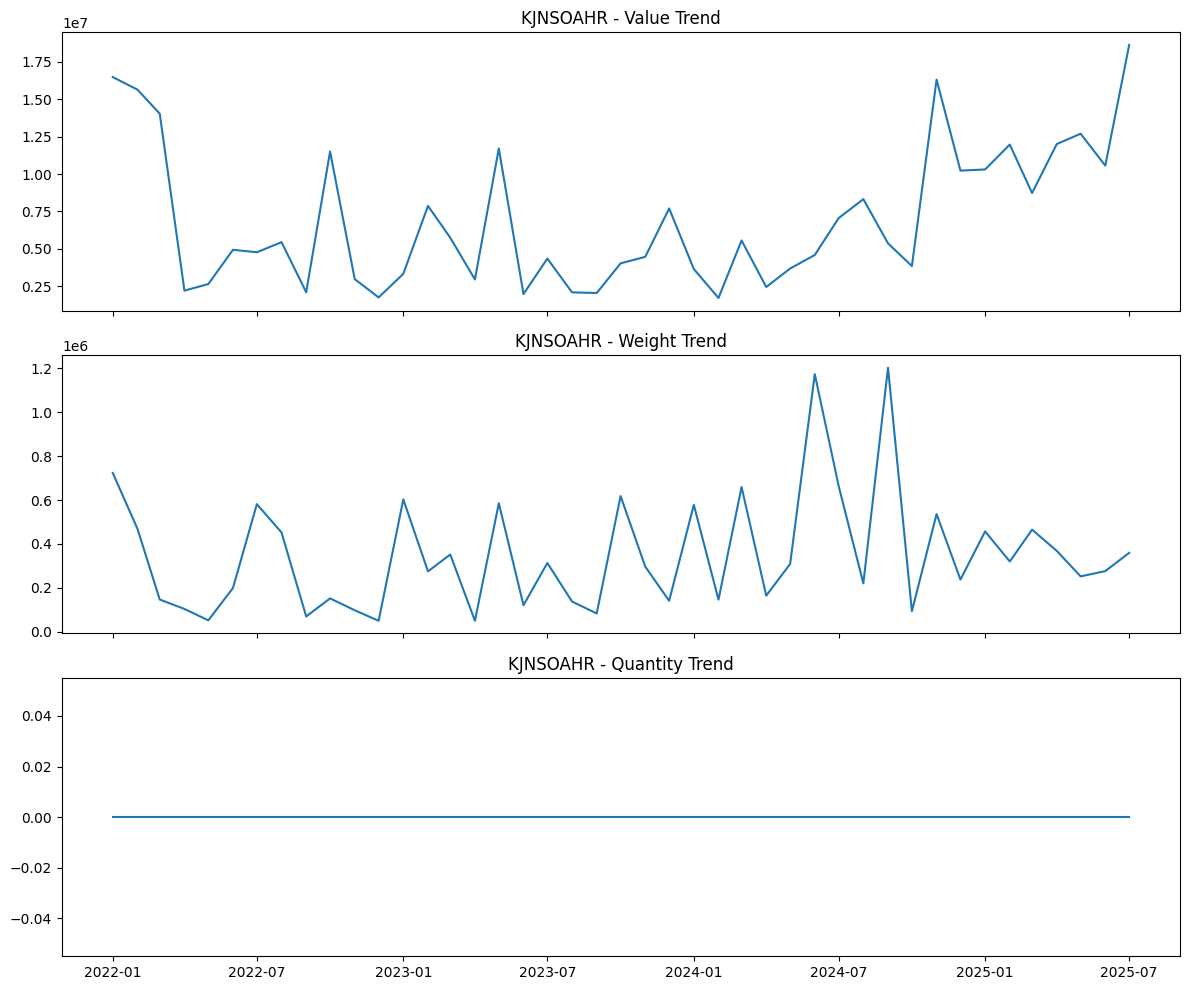

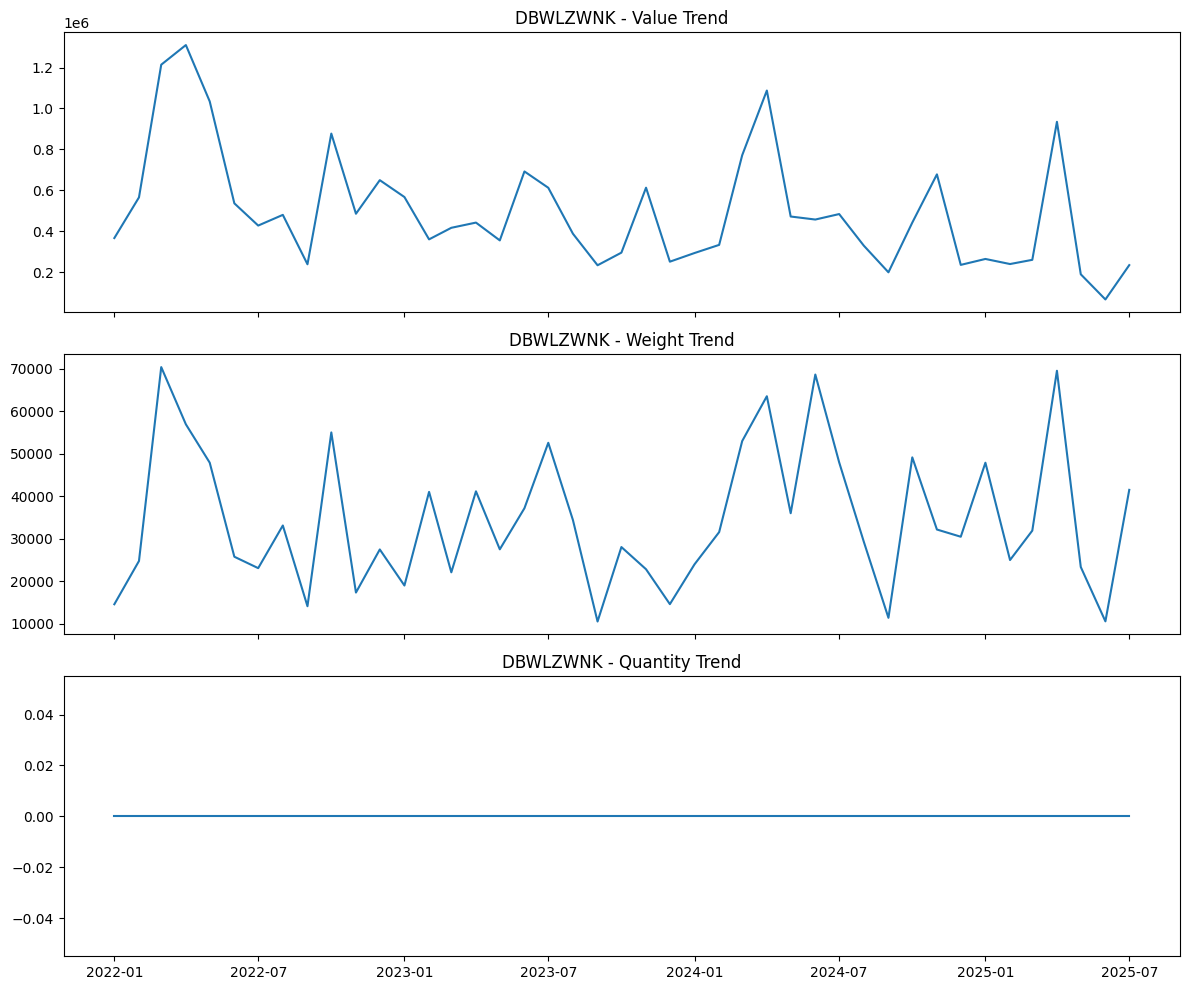

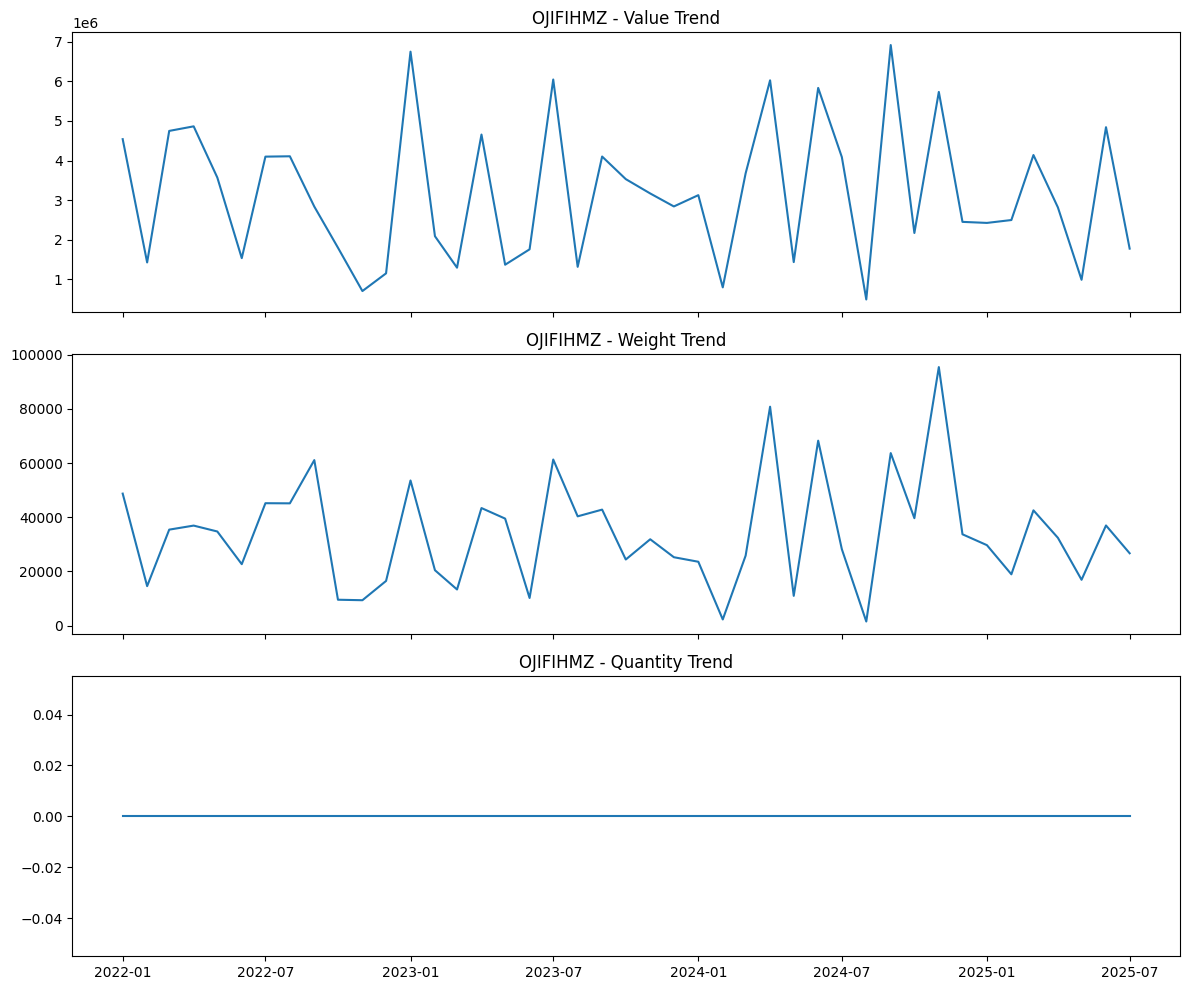

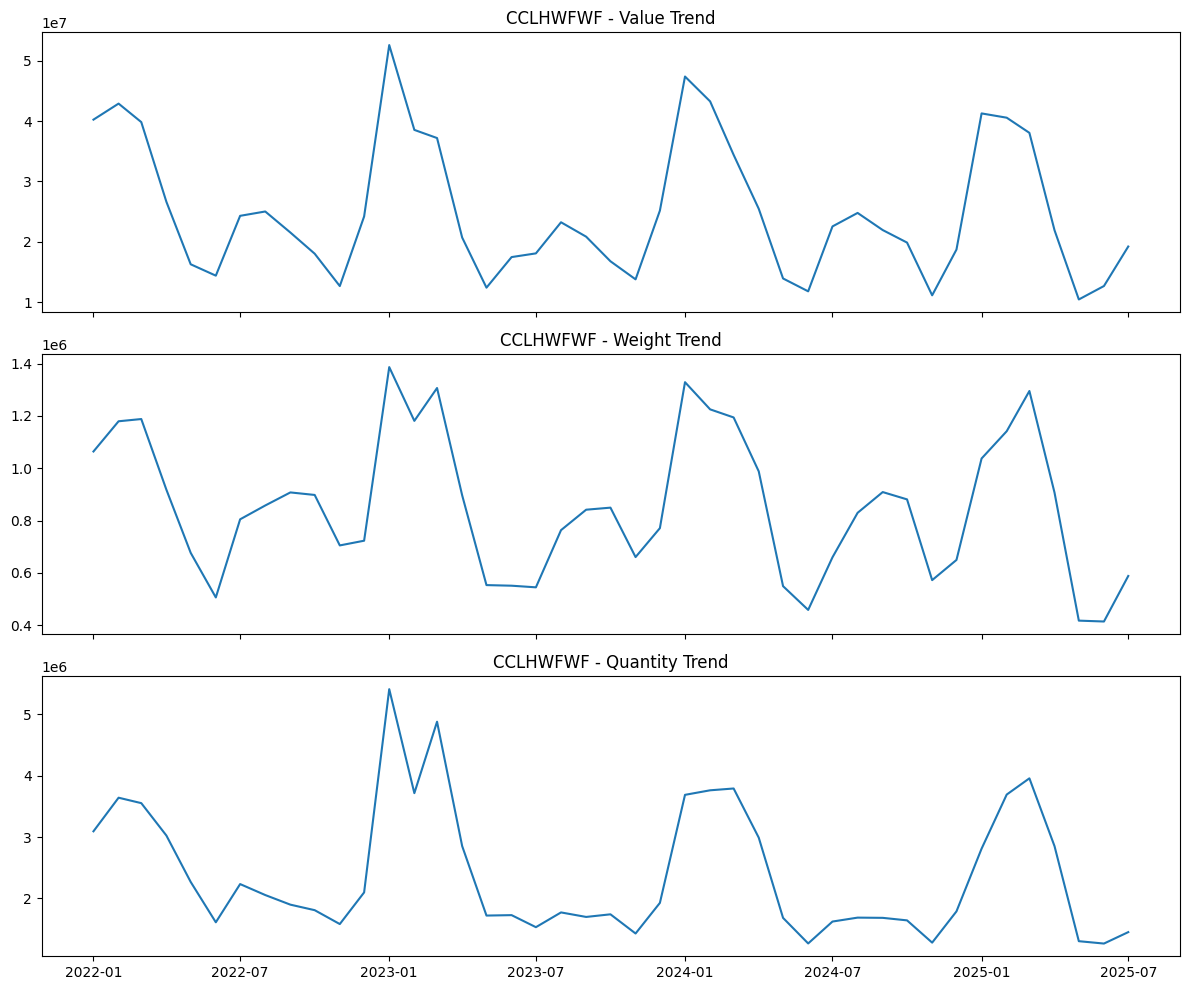

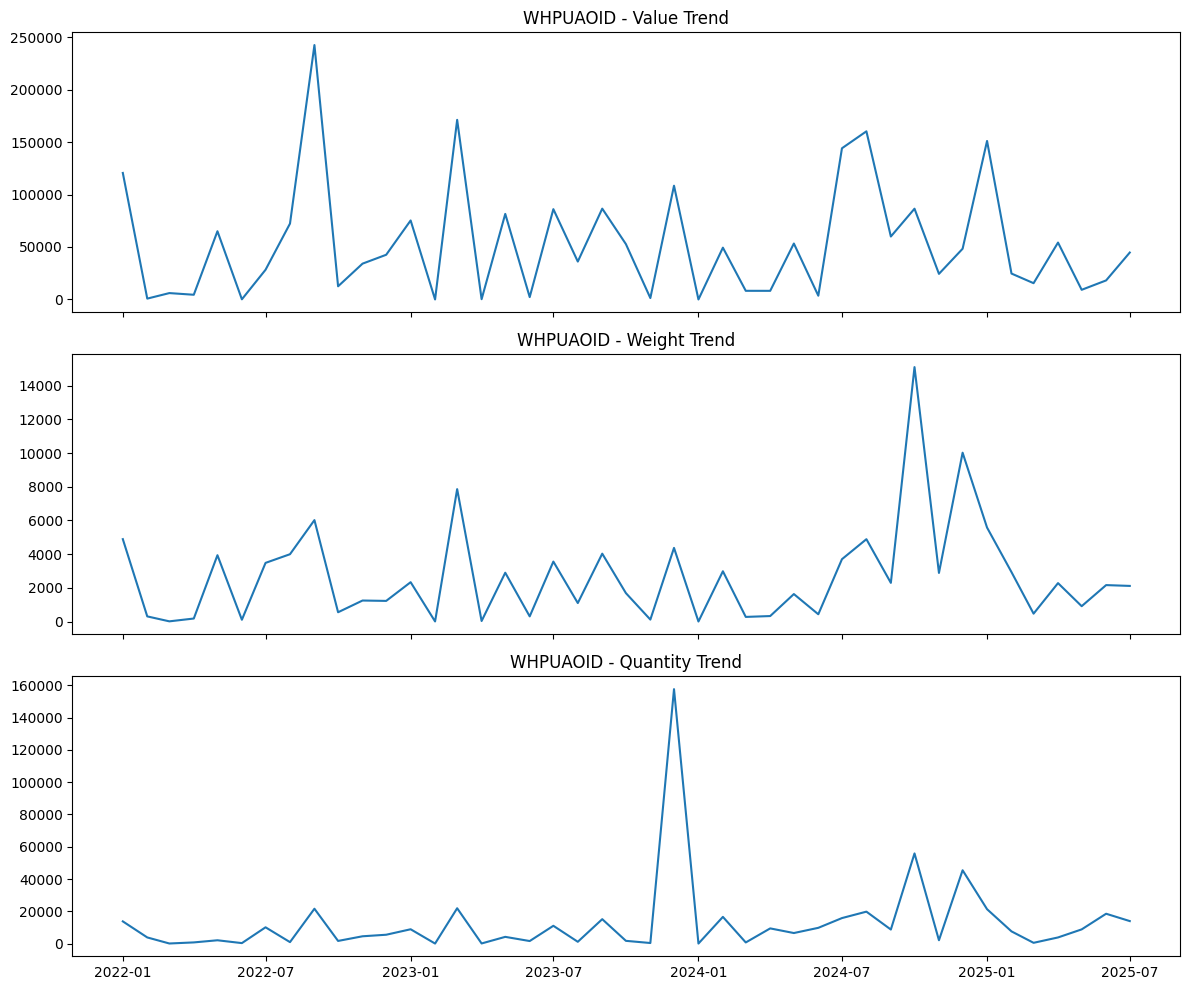

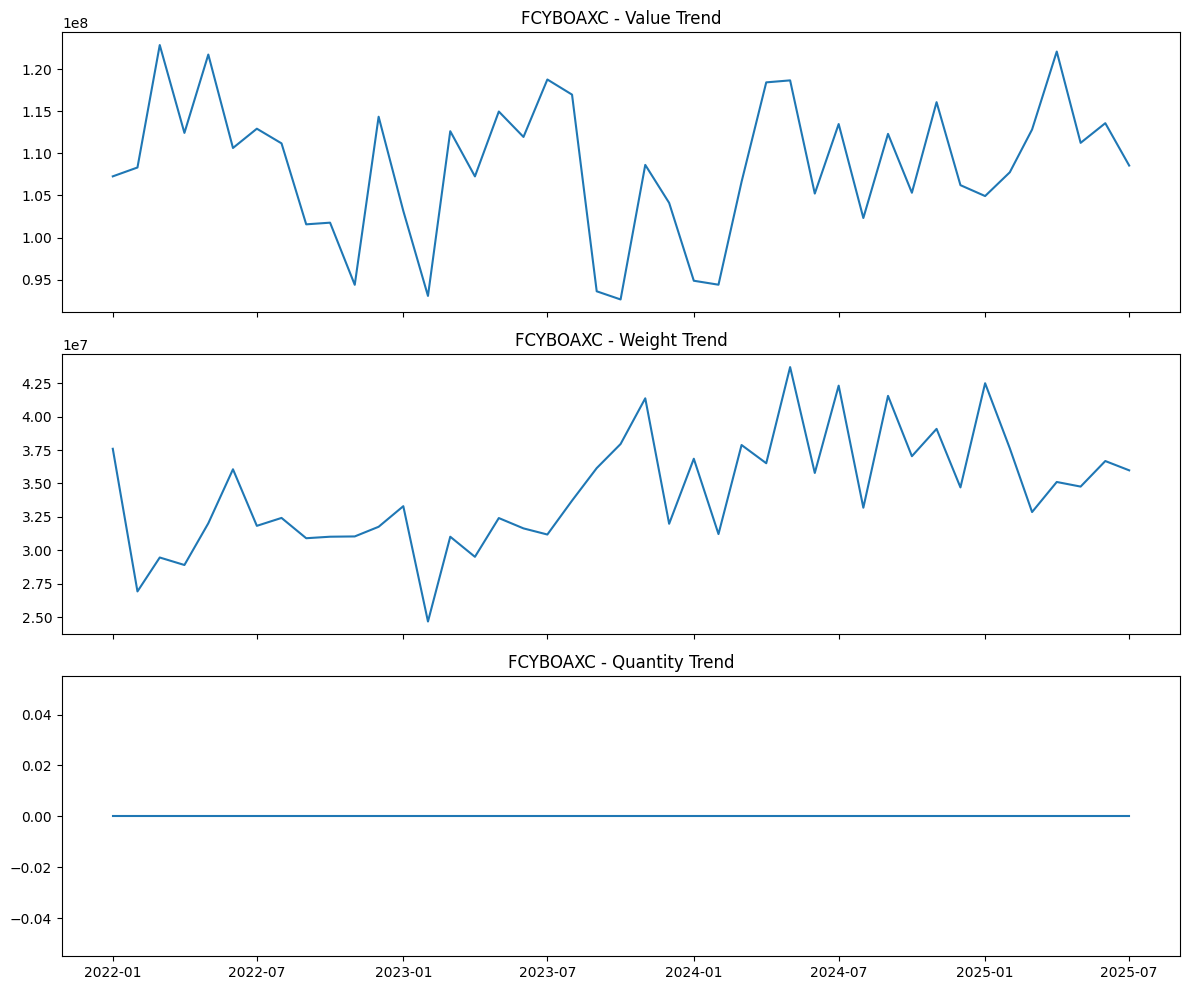

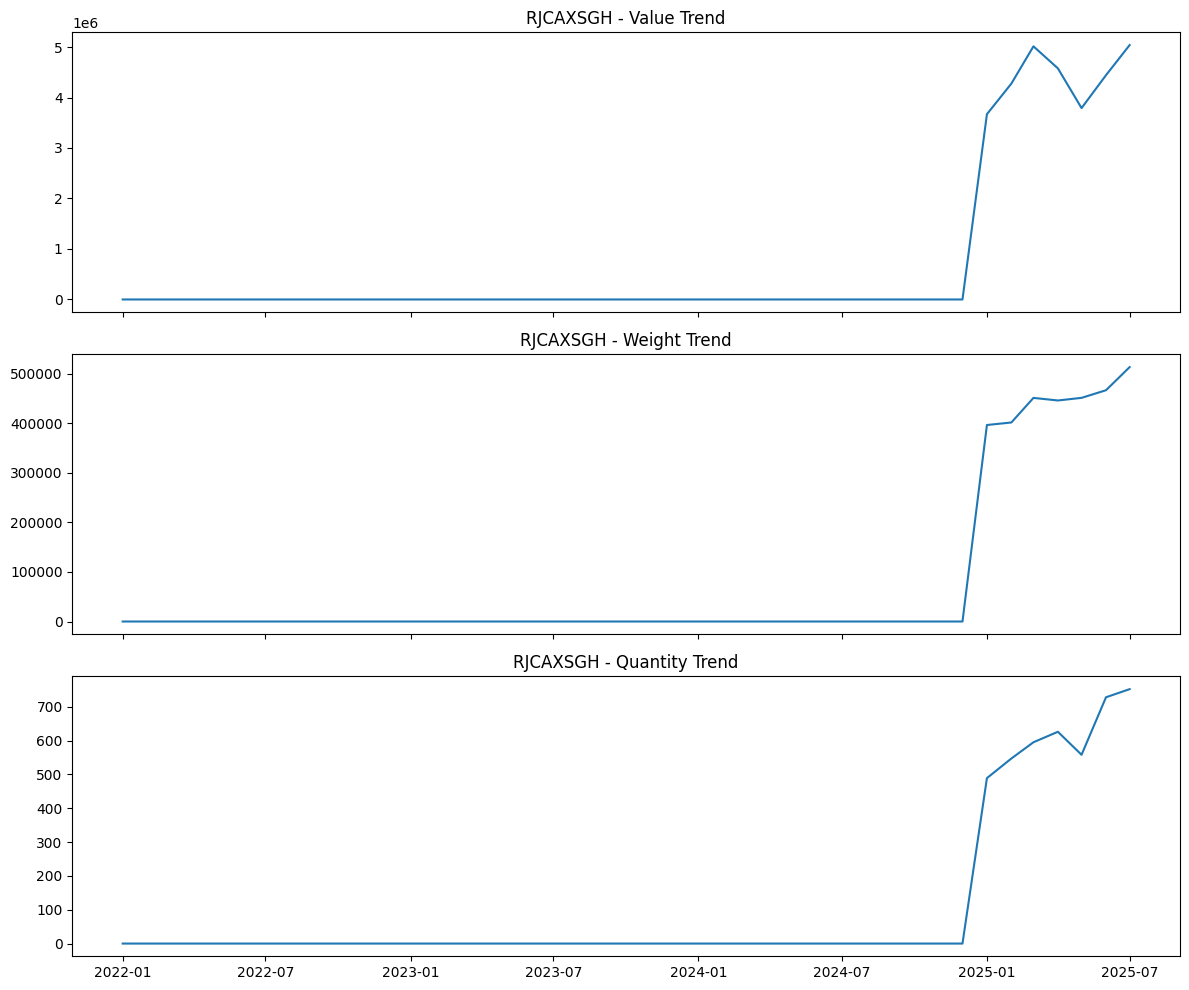

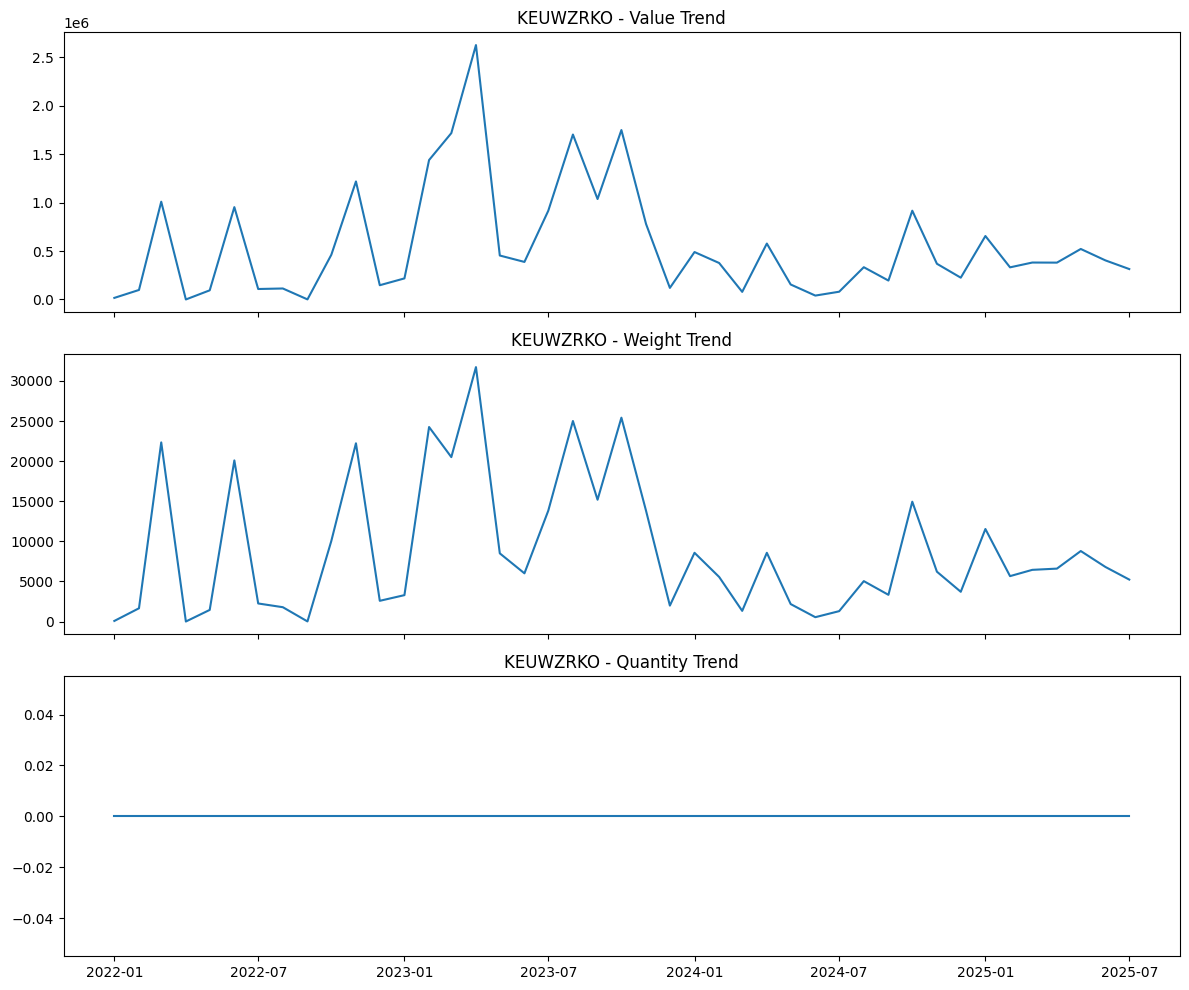

In [25]:
# 각 item_id별 상세 그래프 자동 생성 (value/weight/quantity)
for item in sample_items:
    tmp = monthly_trend[monthly_trend['item_id'] == item]

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(tmp['date'], tmp['value'])
    axes[0].set_title(f"{item} - Value Trend")

    axes[1].plot(tmp['date'], tmp['weight'])
    axes[1].set_title(f"{item} - Weight Trend")

    axes[2].plot(tmp['date'], tmp['quantity'])
    axes[2].set_title(f"{item} - Quantity Trend")

    plt.tight_layout()
    plt.show()